In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import argparse
import os
import torch
import pytorch_lightning as pl
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm, trange

from diffmask.utils.callbacks import CallbackToyTask, CallbackToyTaskDiffMask
from diffmask.models.toy_task import ToyTaskModel
from diffmask.models.toy_task_diffmask import ToyTaskModelDiffMask

from diffmask.attributions.integrated_gradient import integrated_gradient
from diffmask.attributions.schulz import schulz_explainer, toy_hidden_states_statistics
from diffmask.attributions.guan import guan_explainer
from diffmask.utils.getter_setter import toy_getter, toy_setter

# Train the Toy Task model

In [3]:
parser = argparse.ArgumentParser()
parser.add_argument("--gpu", type=str, default="0")
parser.add_argument("--epochs", type=int, default=50)
parser.add_argument("--num_embeddings", type=int, default=10)
parser.add_argument("--embedding_dim", type=int, default=64)
parser.add_argument("--hidden_size", type=int, default=64)
parser.add_argument("--data_size", type=int, default=10000)
parser.add_argument("--data_length", type=int, default=10)
parser.add_argument("--batch_size", type=int, default=128)
parser.add_argument("--learning_rate", type=float, default=1e-3)
parser.add_argument("--learning_rate_alpha", type=float, default=3e-1)    
parser.add_argument("--eps", type=float, default=5e-2)
parser.add_argument("--seed", type=float, default=0)
parser.add_argument(
    "--model_path",
    type=str,
    default="./outputs/toy/version_0/checkpoints",
)
hparams, _ = parser.parse_known_args()

torch.manual_seed(hparams.seed)

os.environ["CUDA_VISIBLE_DEVICES"] = hparams.gpu

In [4]:
model_orig = ToyTaskModel(hparams)

In [5]:
trainer = pl.Trainer(
    gpus=int(hparams.gpu != ""),
    progress_bar_refresh_rate=10,
    max_epochs=hparams.epochs,
    logger=pl.loggers.TensorBoardLogger("outputs", name="toy"),
    callbacks=[CallbackToyTask()]
)

In [6]:
trainer.fit(model_orig)

Epoch 1: Validation accuracy = 63.77


Epoch 2: Validation accuracy = 63.77


Epoch 3: Validation accuracy = 66.69


Epoch 4: Validation accuracy = 80.00


Epoch 5: Validation accuracy = 85.07


Epoch 6: Validation accuracy = 92.23


Epoch 7: Validation accuracy = 93.77


Epoch 8: Validation accuracy = 94.77


Epoch 9: Validation accuracy = 93.43


Epoch 10: Validation accuracy = 97.00


Epoch 11: Validation accuracy = 97.45


Epoch 12: Validation accuracy = 98.17


Epoch 13: Validation accuracy = 97.96


Epoch 14: Validation accuracy = 97.59


Epoch 15: Validation accuracy = 96.84


Epoch 16: Validation accuracy = 97.88


Epoch 17: Validation accuracy = 97.88


Epoch 18: Validation accuracy = 97.76


Epoch 19: Validation accuracy = 98.37


Epoch 20: Validation accuracy = 95.91


Epoch 21: Validation accuracy = 98.61


Epoch 22: Validation accuracy = 99.32


Epoch 23: Validation accuracy = 99.08


Epoch 24: Validation accuracy = 99.71


Epoch 25: Validation accuracy = 96.51


Epoch 26: Validation accuracy = 99.29


Epoch 27: Validation accuracy = 99.90


Epoch 28: Validation accuracy = 99.90


Epoch 29: Validation accuracy = 99.71


Epoch 30: Validation accuracy = 99.71


Epoch 31: Validation accuracy = 99.61


Epoch 32: Validation accuracy = 99.80


Epoch 33: Validation accuracy = 99.90


Epoch 34: Validation accuracy = 99.90


Epoch 35: Validation accuracy = 99.39


Epoch 36: Validation accuracy = 98.69


Epoch 37: Validation accuracy = 99.05


Epoch 38: Validation accuracy = 98.88


Epoch 39: Validation accuracy = 99.71


Epoch 40: Validation accuracy = 99.80


Epoch 41: Validation accuracy = 99.90


Epoch 42: Validation accuracy = 99.80


Epoch 43: Validation accuracy = 99.90


Epoch 44: Validation accuracy = 99.90


Epoch 45: Validation accuracy = 99.90


Epoch 46: Validation accuracy = 99.90


Epoch 47: Validation accuracy = 99.90


Epoch 48: Validation accuracy = 99.90


Epoch 49: Validation accuracy = 99.90


Epoch 50: Validation accuracy = 99.90



1

In [7]:
hparams.model_path_ = os.path.join(hparams.model_path, os.listdir(hparams.model_path)[0])
model_orig = ToyTaskModel.load_from_checkpoint(hparams.model_path_)
model_orig.prepare_data()

# Create an example

In [8]:
device = "cpu:0"
model_orig.to(device)

i = 0
query_ids, input_ids, mask, labels = model_orig.val_dataset[:]
filtered = (
    (labels == 1) 
    & (mask.sum(-1) == 6) 
    & (input_ids == query_ids[:,0].unsqueeze(-1)).any(-1) 
    & (input_ids == query_ids[:,1].unsqueeze(-1)).any(-1)
)
query_ids, input_ids, mask, labels = tuple(e[filtered][i].unsqueeze(0).to(device)
                                           for e in model_orig.val_dataset[:])
attributions_gt = ((input_ids == query_ids[0, 0]) | (input_ids == query_ids[0, 1])).float().cpu()
query_ids, input_ids, mask, labels, attributions_gt

(tensor([[8, 1]]),
 tensor([[8, 8, 3, 1, 3, 9, 0, 0, 0, 0]]),
 tensor([[1, 1, 1, 1, 1, 1, 0, 0, 0, 0]]),
 tensor([1]),
 tensor([[1., 1., 0., 1., 0., 0., 0., 0., 0., 0.]]))

In [9]:
def plot_attribution(
    query_ids,
    input_ids,
    attributions,
    attributions_gt,
    name=None,
    legend=False,
    save=False,
    ymax=1
):
    
    fig, axs = plt.subplots(1, 1,figsize=(6, 4), sharex=True)
    fig.patch.set_facecolor('white')
    plt.xticks(
        torch.arange(input_ids.shape[-1]),
        [r"$\bf{{{}}}$".format(e) if e in query_ids else "${}$".format(e) for e in input_ids],
        size=32
    )
    
    axs.bar(
        torch.arange(input_ids.shape[-1]),
        attributions / attributions.sum(),
        label="attribution"
    )

    axs.locator_params(axis='y', nbins=5)
    axs.axis(ymin=0, ymax=ymax)
    axs.tick_params(axis='y', labelsize=24)
    
    if save:
        plt.savefig(name, bbox_inches="tight", pad_inches=0)
    else:
        plt.show()

In [10]:
hidden_state_idx = 1

# Sundararajan et al. (2017) - Integrated Gradient

In [11]:
attributions_ig = integrated_gradient(
        model_orig,
        {"query_ids": query_ids, "input_ids": input_ids, "mask": mask, "labels": labels},
        getter=toy_getter,
        setter=toy_setter,
        label_getter=lambda outputs, inputs_dict: outputs,
        hidden_state_idx=hidden_state_idx,
        steps=500,
    ).sum(-1).abs().cpu()

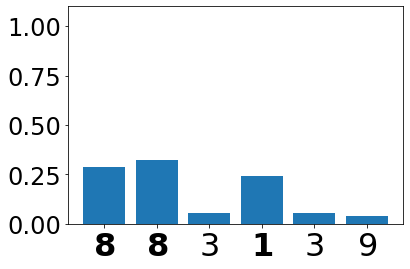

In [12]:
plot_attribution(
    query_ids[0],
    input_ids[0,:mask.sum()],
    attributions_ig[0,:mask.sum()],
    attributions_gt[0,:mask.sum()],
    ymax=1.1
)

# Schulz et al. (2020)

In [13]:
all_q_z_loc, all_q_z_scale = toy_hidden_states_statistics(model_orig)

In [14]:
attributions_schulz = schulz_explainer(
    model_orig,
    {"query_ids": query_ids, "input_ids": input_ids, "labels": labels, "mask": mask},
    getter=toy_getter,
    setter=toy_setter,
    q_z_loc=all_q_z_loc[hidden_state_idx].to(device).unsqueeze(0).detach(),
    q_z_scale=all_q_z_scale[hidden_state_idx].to(device).unsqueeze(0).detach(),
    loss_fn=lambda outputs, hidden_states, inputs_dict: torch.nn.functional.binary_cross_entropy_with_logits(
        outputs, inputs_dict["labels"].float(), reduction="none"
    ).mean(-1),
    loss_kl_fn=lambda kl, inputs_dict: ((
        kl * inputs_dict["mask"]).sum(-1) / inputs_dict["mask"].sum(-1)).mean(-1),
    hidden_state_idx=hidden_state_idx,
    steps=500,
    lr=1e-1,
    la=10,
).cpu()

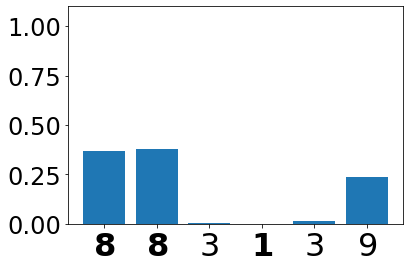

In [15]:
plot_attribution(
    query_ids[0],
    input_ids[0,:mask.sum()],
    attributions_schulz[0,:mask.sum()],
    attributions_gt[0,:mask.sum()],
    ymax=1.1
)

# Guan et al. (2019)

In [16]:
attributions_guan = 1 / guan_explainer(
    model_orig,
    {"query_ids": query_ids, "input_ids": input_ids, "labels": labels, "mask": mask},
    getter=toy_getter,
    setter=toy_setter,
    s_fn=lambda outputs, hidden_states: outputs,
    loss_l2_fn=lambda s, inputs_dict: sum(s_i.sum(-1).mean(-1) for s_i in s),
    loss_h_fn=lambda h, inputs_dict: (h * inputs_dict["mask"]).sum(-1).mean(-1),
    hidden_state_idx=hidden_state_idx,
    steps=500,
    lr=1e-1,
    la=1,
).cpu()

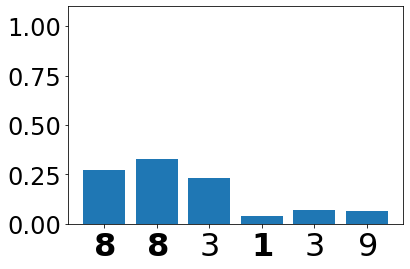

In [17]:
plot_attribution(
    query_ids[0],
    input_ids[0,:mask.sum()],
    attributions_guan[0,:mask.sum()],
    attributions_gt[0,:mask.sum()],
    ymax=1.1,
)

# Plotting latent space

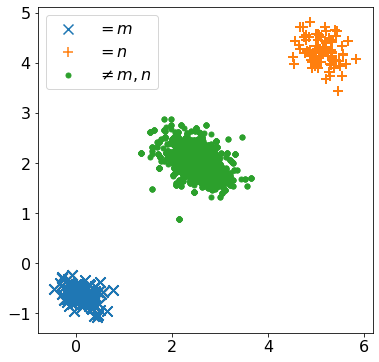

In [18]:
_, hidden_states = toy_getter(model_orig,{
    "query_ids": model_orig.val_dataset[:][0].to(device),
    "input_ids": model_orig.val_dataset[:][1].to(device),
    "mask": model_orig.val_dataset[:][2].to(device),
    "labels": model_orig.val_dataset[:][3].to(device),
},)
hidden_state = hidden_states[2].flatten(0, 1).detach().cpu()[
    model_orig.val_dataset[:][2].flatten(0, 1).bool()
]

plt.figure(figsize=(6, 6))

mask0 = (model_orig.val_dataset[:][1] == model_orig.val_dataset[:][0][:,:1]).flatten(0, 1)[
    model_orig.val_dataset[:][2].flatten(0, 1).bool()
]
plt.scatter(*hidden_state[mask0].T, marker="x", s=100, label="$=m$")

mask1 = (model_orig.val_dataset[:][1] == model_orig.val_dataset[:][0][:,1:]).flatten(0, 1)[
    model_orig.val_dataset[:][2].flatten(0, 1).bool()
]
plt.scatter(*hidden_state[mask1].T, marker="+", s=100, label="$=n$")

plt.scatter(*hidden_state[~mask0 & ~mask1].T, marker=".", s=100, label=r"$\neq m,n$")
plt.legend(fontsize=16, )

plt.tick_params(axis='both', labelsize=16)
# plt.savefig("plots/toy-hidden-projection.pdf", bbox_inches="tight", pad_inches=0)
plt.show()

# Training DiffMask

In [19]:
model = ToyTaskModelDiffMask(hparams)
model.load_state_dict(model_orig.state_dict(), strict=False)
model.train_dataset = model_orig.train_dataset
model.val_dataset = model_orig.val_dataset
model.hparams.learning_rate = 3e-4
model.hparams.learning_rate_alpha = 3e-1
model.hparams.epochs = 100
model.hparams.eps = 0.05

In [20]:
_, hidden_states = toy_getter(model_orig,{
    "query_ids": model_orig.val_dataset[:][0].to(device),
    "input_ids": model_orig.val_dataset[:][1].to(device),
    "mask": model_orig.val_dataset[:][2].to(device),
    "labels": model_orig.val_dataset[:][3].to(device),
},)
model.placeholder[0,0,0].data[:] = hidden_states[1].flatten(0, 1).detach().cpu()[
    model_orig.val_dataset[:][2].flatten(0, 1).bool()
].mean(0)

model.placeholder[0,1,0].data[:2] = hidden_states[2].flatten(0, 1).detach().cpu()[
    model_orig.val_dataset[:][2].flatten(0, 1).bool()
].mean(0)

In [21]:
# Uncomment to load a trained model
# hparams.model_path = "./outputs/toy-diffmask/version_0/checkpoints"
# hparams.model_path_ = os.path.join(hparams.model_path, os.listdir(hparams.model_path)[0])
# model = ToyTaskModelDiffMask.load_from_checkpoint(hparams.model_path_).to(device)
# model.to(device)
# model.train_dataset = model_orig.train_dataset
# model.val_dataset = model_orig.val_dataset

In [22]:
trainer = pl.Trainer(
    gpus=int(hparams.gpu != ""),
    progress_bar_refresh_rate=10,
    max_epochs=hparams.epochs,
    logger=pl.loggers.TensorBoardLogger("outputs", name="toy-diffmask"),
    callbacks=[CallbackToyTaskDiffMask()],
)

In [23]:
trainer.fit(model)

Epoch 1: Validation accuracy = 97.24, gates at zero = 1.30%, constraint = 0.13183


Epoch 2: Validation accuracy = 98.73, gates at zero = 0.70%, constraint = 0.05812


Epoch 3: Validation accuracy = 99.29, gates at zero = 0.52%, constraint = 0.04056


Epoch 4: Validation accuracy = 99.08, gates at zero = 0.36%, constraint = 0.03725


Epoch 5: Validation accuracy = 99.00, gates at zero = 0.65%, constraint = 0.03423


Epoch 6: Validation accuracy = 98.78, gates at zero = 0.74%, constraint = 0.04446


Epoch 7: Validation accuracy = 99.32, gates at zero = 0.72%, constraint = 0.02365


Epoch 8: Validation accuracy = 98.73, gates at zero = 1.09%, constraint = 0.06442


Epoch 9: Validation accuracy = 99.32, gates at zero = 0.46%, constraint = 0.02213


Epoch 10: Validation accuracy = 99.10, gates at zero = 0.58%, constraint = 0.04627


Epoch 11: Validation accuracy = 99.61, gates at zero = 0.16%, constraint = 0.01423


Epoch 12: Validation accuracy = 99.22, gates at zero = 0.19%, constraint = 0.03230


Epoch 13: Validation accuracy = 98.81, gates at zero = 0.85%, constraint = 0.05705


Epoch 14: Validation accuracy = 99.66, gates at zero = 0.17%, constraint = 0.00715


Epoch 15: Validation accuracy = 99.41, gates at zero = 0.19%, constraint = 0.01768


Epoch 16: Validation accuracy = 99.71, gates at zero = 0.22%, constraint = 0.00801


Epoch 17: Validation accuracy = 99.41, gates at zero = 0.29%, constraint = 0.01515


Epoch 18: Validation accuracy = 99.51, gates at zero = 0.29%, constraint = 0.01673


Epoch 19: Validation accuracy = 99.17, gates at zero = 0.80%, constraint = 0.03560


Epoch 20: Validation accuracy = 99.41, gates at zero = 0.28%, constraint = 0.03105


Epoch 21: Validation accuracy = 99.41, gates at zero = 0.58%, constraint = 0.02455


Epoch 22: Validation accuracy = 99.00, gates at zero = 1.27%, constraint = 0.04267


Epoch 23: Validation accuracy = 99.90, gates at zero = 0.28%, constraint = 0.00035


Epoch 24: Validation accuracy = 98.81, gates at zero = 0.79%, constraint = 0.04266


Epoch 25: Validation accuracy = 99.51, gates at zero = 0.36%, constraint = 0.02374


Epoch 26: Validation accuracy = 99.59, gates at zero = 0.45%, constraint = 0.01589


Epoch 27: Validation accuracy = 99.08, gates at zero = 0.34%, constraint = 0.04156


Epoch 28: Validation accuracy = 99.41, gates at zero = 0.41%, constraint = 0.01993


Epoch 29: Validation accuracy = 99.71, gates at zero = 0.53%, constraint = 0.00661


Epoch 30: Validation accuracy = 99.08, gates at zero = 0.75%, constraint = 0.03115


Epoch 31: Validation accuracy = 99.29, gates at zero = 0.39%, constraint = 0.02636


Epoch 32: Validation accuracy = 99.22, gates at zero = 0.77%, constraint = 0.02574


Epoch 33: Validation accuracy = 99.80, gates at zero = 0.46%, constraint = 0.00383


Epoch 34: Validation accuracy = 99.22, gates at zero = 0.65%, constraint = 0.02654


Epoch 35: Validation accuracy = 99.20, gates at zero = 1.31%, constraint = 0.02266


Epoch 36: Validation accuracy = 99.49, gates at zero = 0.90%, constraint = 0.01544


Epoch 37: Validation accuracy = 98.41, gates at zero = 1.85%, constraint = 0.05719


Epoch 38: Validation accuracy = 98.93, gates at zero = 2.12%, constraint = 0.03515


Epoch 39: Validation accuracy = 99.37, gates at zero = 1.68%, constraint = 0.02270


Epoch 40: Validation accuracy = 99.12, gates at zero = 2.30%, constraint = 0.02430


Epoch 41: Validation accuracy = 99.68, gates at zero = 1.86%, constraint = 0.01683


Epoch 42: Validation accuracy = 98.59, gates at zero = 6.74%, constraint = 0.04706


Epoch 43: Validation accuracy = 98.93, gates at zero = 5.61%, constraint = 0.03374


Epoch 44: Validation accuracy = 99.20, gates at zero = 3.73%, constraint = 0.02102


Epoch 45: Validation accuracy = 99.39, gates at zero = 5.94%, constraint = 0.01894


Epoch 46: Validation accuracy = 98.88, gates at zero = 9.94%, constraint = 0.03758


Epoch 47: Validation accuracy = 99.71, gates at zero = 4.94%, constraint = 0.00832


Epoch 48: Validation accuracy = 99.29, gates at zero = 10.55%, constraint = 0.01791


Epoch 49: Validation accuracy = 99.08, gates at zero = 12.41%, constraint = 0.02966


Epoch 50: Validation accuracy = 99.10, gates at zero = 10.18%, constraint = 0.03354


Epoch 51: Validation accuracy = 99.17, gates at zero = 10.05%, constraint = 0.02004


Epoch 52: Validation accuracy = 98.81, gates at zero = 20.11%, constraint = 0.03594


Epoch 53: Validation accuracy = 98.76, gates at zero = 21.92%, constraint = 0.03415


Epoch 54: Validation accuracy = 99.20, gates at zero = 12.66%, constraint = 0.03168


Epoch 55: Validation accuracy = 98.73, gates at zero = 12.69%, constraint = 0.05584


Epoch 56: Validation accuracy = 98.98, gates at zero = 18.80%, constraint = 0.03535


Epoch 57: Validation accuracy = 99.29, gates at zero = 22.48%, constraint = 0.01801


Epoch 58: Validation accuracy = 98.37, gates at zero = 20.44%, constraint = 0.07570


Epoch 59: Validation accuracy = 97.66, gates at zero = 30.74%, constraint = 0.08009


Epoch 60: Validation accuracy = 99.12, gates at zero = 15.27%, constraint = 0.02546


Epoch 61: Validation accuracy = 97.69, gates at zero = 37.16%, constraint = 0.07612


Epoch 62: Validation accuracy = 98.83, gates at zero = 28.54%, constraint = 0.03749


Epoch 63: Validation accuracy = 98.39, gates at zero = 15.93%, constraint = 0.05275


Epoch 64: Validation accuracy = 98.59, gates at zero = 31.48%, constraint = 0.04530


Epoch 65: Validation accuracy = 97.22, gates at zero = 12.32%, constraint = 0.11358


Epoch 66: Validation accuracy = 99.22, gates at zero = 16.06%, constraint = 0.02553


Epoch 67: Validation accuracy = 99.47, gates at zero = 20.65%, constraint = 0.02016


Epoch 68: Validation accuracy = 98.93, gates at zero = 32.08%, constraint = 0.04257


Epoch 69: Validation accuracy = 98.81, gates at zero = 21.74%, constraint = 0.04420


Epoch 70: Validation accuracy = 97.98, gates at zero = 22.73%, constraint = 0.09407


Epoch 71: Validation accuracy = 99.29, gates at zero = 21.84%, constraint = 0.02602


Epoch 72: Validation accuracy = 99.41, gates at zero = 16.12%, constraint = 0.01337


Epoch 73: Validation accuracy = 98.83, gates at zero = 11.41%, constraint = 0.04142


Epoch 74: Validation accuracy = 98.96, gates at zero = 22.62%, constraint = 0.03631


Epoch 75: Validation accuracy = 99.00, gates at zero = 16.77%, constraint = 0.03534


Epoch 76: Validation accuracy = 98.96, gates at zero = 23.18%, constraint = 0.03031


Epoch 77: Validation accuracy = 98.52, gates at zero = 22.75%, constraint = 0.06211


Epoch 78: Validation accuracy = 99.41, gates at zero = 11.39%, constraint = 0.01830


Epoch 79: Validation accuracy = 99.17, gates at zero = 22.48%, constraint = 0.02885


Epoch 80: Validation accuracy = 99.32, gates at zero = 22.66%, constraint = 0.02353


Epoch 81: Validation accuracy = 99.12, gates at zero = 17.58%, constraint = 0.03355


Epoch 82: Validation accuracy = 98.69, gates at zero = 22.92%, constraint = 0.05156


Epoch 83: Validation accuracy = 98.34, gates at zero = 12.42%, constraint = 0.07766


Epoch 84: Validation accuracy = 99.39, gates at zero = 17.43%, constraint = 0.01825


Epoch 85: Validation accuracy = 98.17, gates at zero = 17.69%, constraint = 0.06142


Epoch 86: Validation accuracy = 98.90, gates at zero = 18.04%, constraint = 0.04023


Epoch 87: Validation accuracy = 99.20, gates at zero = 23.60%, constraint = 0.02830


Epoch 88: Validation accuracy = 99.12, gates at zero = 17.91%, constraint = 0.02888


Epoch 89: Validation accuracy = 98.83, gates at zero = 23.80%, constraint = 0.03745


Epoch 90: Validation accuracy = 98.83, gates at zero = 17.97%, constraint = 0.04849


Epoch 91: Validation accuracy = 99.22, gates at zero = 23.42%, constraint = 0.03537


Epoch 92: Validation accuracy = 98.73, gates at zero = 30.09%, constraint = 0.05943


Epoch 93: Validation accuracy = 99.12, gates at zero = 12.14%, constraint = 0.03097


Epoch 94: Validation accuracy = 98.66, gates at zero = 30.09%, constraint = 0.05192


Epoch 95: Validation accuracy = 99.35, gates at zero = 11.96%, constraint = 0.01454


Epoch 96: Validation accuracy = 98.78, gates at zero = 35.92%, constraint = 0.03870


Epoch 97: Validation accuracy = 98.02, gates at zero = 30.72%, constraint = 0.07147


Epoch 98: Validation accuracy = 99.00, gates at zero = 12.34%, constraint = 0.03561


Epoch 99: Validation accuracy = 98.59, gates at zero = 7.07%, constraint = 0.04416


Epoch 100: Validation accuracy = 99.08, gates at zero = 29.98%, constraint = 0.03267



1

In [24]:
model.to(device)

attributions_ours = [
    model.forward_explainer(
        query_ids=query_ids,
        input_ids=input_ids,
        mask=mask,
        layer_drop=0,
        layer_pred=0,
    )[3].exp().cpu().detach(),
    model.forward_explainer(
        query_ids=query_ids,
        input_ids=input_ids,
        mask=mask,
        layer_drop=1,
        layer_pred=1,
    )[3].exp().cpu().detach(),
]

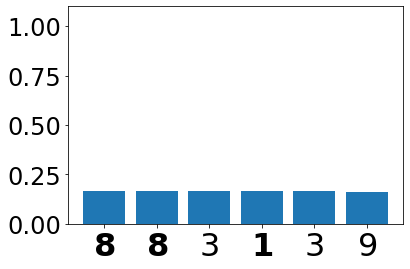

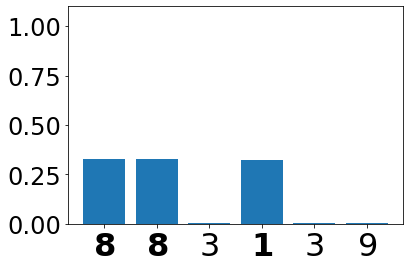

In [25]:
plot_attribution(
    query_ids[0],
    input_ids[0,:mask.sum()],
    attributions_ours[0][0,:mask.sum()],
    attributions_gt[0,:mask.sum()],
    name="plots/toy-ours-input.pdf",
    ymax=1.1,
)

plot_attribution(
    query_ids[0],
    input_ids[0,:mask.sum()],
    attributions_ours[1][0,:mask.sum()],
    attributions_gt[0,:mask.sum()],
    name="plots/toy-ours-hidden.pdf",
    ymax=1.1,
)

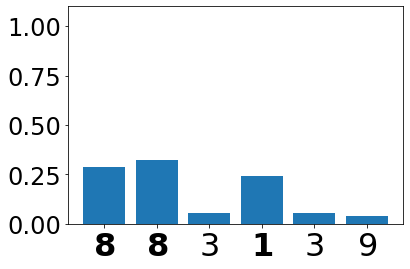

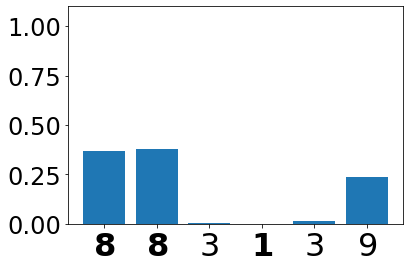

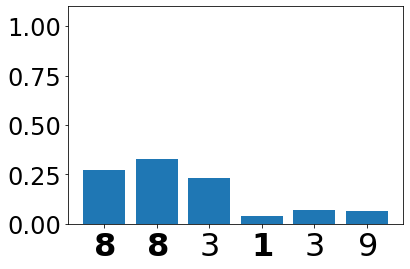

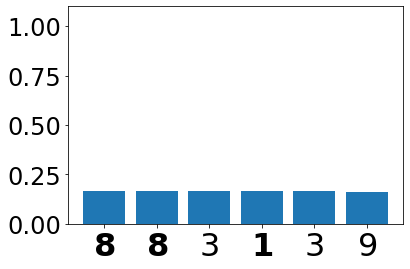

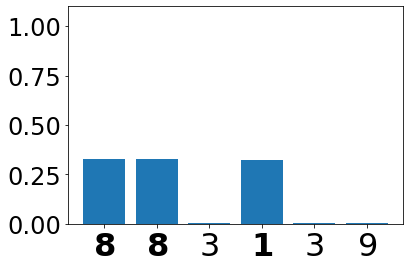

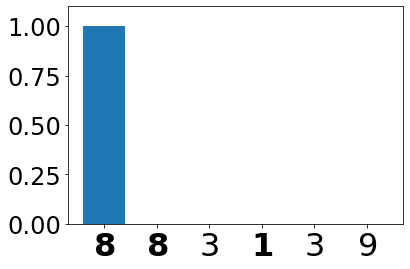

In [26]:
plot_attribution(
    query_ids[0],
    input_ids[0,:mask.sum()],
    attributions_ig[0,:mask.sum()],
    attributions_gt[0,:mask.sum()],
    name="plots/toy-ig.pdf",
    ymax=1.1,
    save=True
)
plot_attribution(
    query_ids[0],
    input_ids[0,:mask.sum()],
    attributions_schulz[0,:mask.sum()],
    attributions_gt[0,:mask.sum()],
    "plots/toy-schulz.pdf",
    ymax=1.1,
    save=True
)
plot_attribution(
    query_ids[0],
    input_ids[0,:mask.sum()],
    attributions_guan[0,:mask.sum()],
    attributions_gt[0,:mask.sum()],
    "plots/toy-guan.pdf",
    ymax=1.1,
    save=True
)
plot_attribution(
    query_ids[0],
    input_ids[0,:mask.sum()],
    attributions_ours[0][0,:mask.sum()],
    attributions_gt[0,:mask.sum()],
    "plots/toy-ours-input.pdf",
    ymax=1.1,
    save=True,
    legend=True
)
plot_attribution(
    query_ids[0],
    input_ids[0,:mask.sum()],
    attributions_ours[1][0,:mask.sum()],
    attributions_gt[0,:mask.sum()],
    "plots/toy-ours-hidden.pdf",
    ymax=1.1,
    save=True,
    legend=True
)

plot_attribution(
    query_ids[0],
    input_ids[0,:mask.sum()],
    torch.tensor([1] + [0] * (mask.sum().item() - 1)),
    attributions_gt[0,:mask.sum()],
    "plots/toy-exact.pdf",
    ymax=1.1,
    save=True,
    legend=True
)

# Evaluate on all validation set

In [27]:
hidden_state_idx = 2

In [28]:
attributions_ig_all = integrated_gradient(
    model_orig,
    {
        "query_ids": model_orig.val_dataset[:][0].to(device),
        "input_ids": model_orig.val_dataset[:][1].to(device),
        "mask": model_orig.val_dataset[:][2].to(device),
        "labels": model_orig.val_dataset[:][3].to(device),
    },
    getter=toy_getter,
    setter=toy_setter,
    label_getter=lambda outputs, inputs_dict: outputs,
    hidden_state_idx=hidden_state_idx,
    steps=500,
).sum(-1).abs().cpu() * model_orig.val_dataset[:][2]

In [29]:
attributions_schulz_all = schulz_explainer(
    model_orig,
    {
        "query_ids": model.val_dataset[:][0].to(device),
        "input_ids": model.val_dataset[:][1].to(device),
        "mask": model.val_dataset[:][2].to(device),
        "labels": model.val_dataset[:][3].to(device),
    },
    getter=toy_getter,
    setter=toy_setter,
    q_z_loc=all_q_z_loc[hidden_state_idx].to(device).unsqueeze(0).detach(),
    q_z_scale=all_q_z_scale[hidden_state_idx].to(device).unsqueeze(0).detach(),
    loss_fn=lambda outputs, hidden_states, inputs_dict: torch.nn.functional.binary_cross_entropy_with_logits(
        outputs, inputs_dict["labels"].float(), reduction="none"
    ).mean(-1),
    loss_kl_fn=lambda kl, inputs_dict: kl.mean(-1).mean(-1),
    hidden_state_idx=hidden_state_idx,
    steps=500,
    lr=1e-1,
    la=10,
).cpu() * model.val_dataset[:][2]

In [30]:
attributions_guan_all = 1 / guan_explainer(
    model_orig,
    {
        "query_ids": model.val_dataset[:][0].to(device),
        "input_ids": model.val_dataset[:][1].to(device),
        "mask": model.val_dataset[:][2].to(device),
        "labels": model.val_dataset[:][3].to(device),
    },
    getter=toy_getter,
    setter=toy_setter,
    s_fn=lambda outputs, hidden_states: outputs,
    loss_l2_fn=lambda s, inputs_dict: sum(s_i.sum(-1).mean(-1) for s_i in s),
    loss_h_fn=lambda h, inputs_dict: h.sum(-1).mean(-1),
    hidden_state_idx=hidden_state_idx,
    steps=500,
    lr=1e-1,
    la=1,
).cpu() * model.val_dataset[:][2]

In [31]:
attributions_ours_all = model.forward_explainer(
    query_ids=model.val_dataset[:][0].to(device),
    input_ids=model.val_dataset[:][1].to(device),
    mask=model.val_dataset[:][2].to(device),
    layer_drop=1,
    layer_pred=1,
)[3].exp().cpu() * model.val_dataset[:][2]

In [32]:
attributions_gt_all = ((model.val_dataset[:][1] == model.val_dataset[:][0][:,:1]) | (
    model.val_dataset[:][1] == model.val_dataset[:][0][:,1:])).float().cpu() * model.val_dataset[:][2]

In [33]:
attributions_exact_tmp = (torch.where(
    model.val_dataset[:][3].unsqueeze(-1).bool(),
    (model.val_dataset[:][1] == model.val_dataset[:][0][:,:1]).float(),
    (model.val_dataset[:][1] == model.val_dataset[:][0][:,1:]).float(),
) * model.val_dataset[:][2])
attributions_exact = torch.zeros_like(attributions_exact_tmp)
attributions_exact[attributions_exact_tmp.sum(-1) > 0,
                   attributions_exact_tmp[attributions_exact_tmp.sum(-1) > 0].argmax(-1),] = 1

In [34]:
import pandas as pd
from collections import defaultdict

In [35]:
metrics = defaultdict(dict)

for method_name, attr in zip(
    ("exact", "ig", "cv", "nlp", "ours"),
    (attributions_exact, attributions_ig_all, attributions_schulz_all, attributions_guan_all, attributions_ours_all)
):

    attr = attr[attributions_gt_all.sum(-1) > 0]
    
    p = torch.distributions.Categorical(probs=attr / attr.sum(-1, keepdim=True))
    q = torch.distributions.Categorical(
        probs=(attributions_gt_all / attributions_gt_all.sum(-1, keepdim=True))[attributions_gt_all.sum(-1) > 0]
    )
    m = torch.distributions.Categorical(probs=0.5 * (p.probs + q.probs))

    metrics[method_name]["$D_\mathrm{KL}$"] = torch.distributions.kl_divergence(q, p)

    metrics[method_name]["$D_\mathrm{JS}$"] = 0.5 * (
        torch.distributions.kl_divergence(p, m) + torch.distributions.kl_divergence(q, m)
    )
    

In [36]:
pd.DataFrame(
    {k: {kk: "{:.4f} +/- {:.3f}".format(vv.mean().item(), vv.std().item()) for kk, vv in v.items()} 
     for k, v in metrics.items()}
).T

,$D_\mathrm{KL}$,$D_\mathrm{JS}$
exact,inf +/- nan,0.2664 +/- 0.156
ig,1.3166 +/- 0.914,0.2686 +/- 0.151
cv,1.1296 +/- 0.702,0.1837 +/- 0.089
nlp,0.8825 +/- 0.548,0.2380 +/- 0.134
ours,0.0277 +/- 0.028,0.0095 +/- 0.010


In [37]:
name_map = {
    "exact": "Exact",
    "ig": "\citet{sundararajan2017axiomatic}",
    "cv": "\citet{schulz2020restricting}",
    "nlp": "\citet{guan2019towards}",
    "ours": "\textsc{DiffMask}",
}

print(
    pd.DataFrame(
        {name_map[k]: 
         {kk:
          "${:.2f}$".format(vv.mean().item(), vv.std().item())
          for kk, vv in v.items()
         } 
         for k, v in metrics.items()
        }
    ).T.to_latex()
    .replace("\$", "$")
    .replace(r"\textbackslash ", "\\")
    .replace("\{", "{")
    .replace("\}", "}")
    .replace("\_", "_")
)

\begin{tabular}{lll}
\toprule
{} & $D_\mathrm{KL}$ & $D_\mathrm{JS}$ \\
\midrule
Exact                             &           $inf$ &          $0.27$ \\
\citet{sundararajan2017axiomatic} &          $1.32$ &          $0.27$ \\
\citet{schulz2020restricting}     &          $1.13$ &          $0.18$ \\
\citet{guan2019towards}           &          $0.88$ &          $0.24$ \\
\textsc{DiffMask}                 &          $0.03$ &          $0.01$ \\
\bottomrule
\end{tabular}

